# Bayesian Logistic Regression

Leaving the universe of linear models, we start to venture into generalized linear models (GLM). The first is
**logistic regression** (also called binomial regression).

A logistic regression behaves exactly like a linear model: it makes a prediction simply by computing a weighted
sum of the independent variables $\mathbf{X}$ by the estimated coefficients $\boldsymbol{\beta}$, plus an intercept
$\alpha$. However, instead of returning a continuous value $y$, such as linear regression, it returns the **logistic
function** of $y$:

$$ \text{Logistic}(x) = \frac{1}{1 + e^{(-x)}} $$

We use logistic regression when our dependent variable is binary. It has only two distinct values, usually
encoded as $0$ or $1$. See the figure below for a graphical intuition of the logistic function:

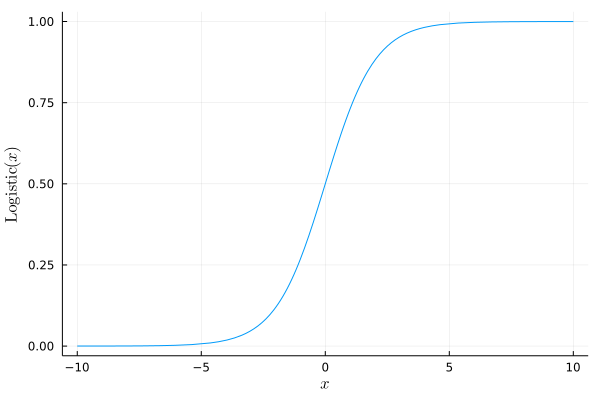

In [9]:
using Plots, LaTeXStrings

function logistic(x)
    return 1 / (1 + exp(-x))
end

plot(logistic, -10, 10, label=false,
     xlabel=L"x", ylabel=L"\mathrm{Logistic}(x)")


\fig{logistic}
\center{*Logistic Function*} \\

As we can see, the logistic function is basically a mapping of any real number to a
real number in the range between 0 and 1:

$$ \text{Logistic}(x) = \{ \mathbb{R} \in [- \infty , + \infty] \} \to \{ \mathbb{R} \in (0, 1) \} $$

That is, the logistic function is the ideal candidate for when we need to convert something continuous without restrictions
to something continuous restricted between 0 and 1. That is why it is used when we need a model to have a probability as a
dependent variable (remembering that any real number between 0 and 1 is a valid probability). In the case of a binary dependent
variable, we can use this probability as the chance of the dependent variable taking a value of 0 or 1.

## Comparison with Linear Regression

Linear regression follows the following mathematical formulation:

$$ \text{Linear} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n $$

* $\theta$ - model parameters
  * $\theta_0$ - intercept
  * $\theta_1, \theta_2, \dots$ - independent variables $x_1, x_2, \dots$ coefficients
* $n$ - total number of independent variables

Logistic regression would add the logistic function to the linear term:

* $\hat{p} = \text{Logistic}(\text{Linear}) = \frac{1}{1 + e^{-\operatorname{Linear}}}$ - predicted probability of the observation being the value 1
* $\hat{\mathbf{y}}=\left\{\begin{array}{ll} 0 & \text { if } \hat{p} < 0.5 \\ 1 & \text { if } \hat{p} \geq 0.5 \end{array}\right.$ - predicted discrete value of $\mathbf{y}$

**Example**:

$$ \text{Probability of Death} = \text{Logistic} \big(-10 + 10 \cdot \text{cancer} + 12 \cdot \text{diabetes} + 8 \cdot \text{obesity} \big) $$

## Bayesian Logistic Regression

We can model logistic regression in two ways. The first option with a **Bernoulli likelihood** function and the second option with
a **binomial likelihood** function.

With the **Bernoulli likelihood** we model a binary dependent variable $y$ which is the result of a Bernoulli trial with
a certain probability $p$.

In a **binomial likelihood**, we model a continuous dependent variable $y$ which is the number of successes of $n$
independent Bernoulli trials.

### Using Bernoulli Likelihood

$$
\begin{aligned}
\mathbf{y} &\sim \text{Bernoulli}\left( p \right) \\
\mathbf{p} &\sim \text{Logistic}(\alpha + \mathbf{X} \cdot \boldsymbol{\beta}) \\
\alpha &\sim \text{Normal}(\mu_\alpha, \sigma_\alpha) \\
\boldsymbol{\beta} &\sim \text{Normal}(\mu_{\boldsymbol{\beta}}, \sigma_{\boldsymbol{\beta}})
\end{aligned}
$$

where:

* $\mathbf{y}$ -- binary dependent variable.
* $\mathbf{p}$ -- probability of $\mathbf{y}$ taking the value of $\mathbf{y}$ -- success of an independent Bernoulli trial.
* $\text{Logistic}$ -- logistic function.
* $\alpha$ -- intercept.
* $\boldsymbol{\beta}$ -- coefficient vector.
* $\mathbf{X}$ -- data matrix.

### Using Binomial Likelihood

$$
\begin{aligned}
\mathbf{y} &\sim \text{Binomial}\left( n, p \right) \\
\mathbf{p} &\sim \text{Logistic}(\alpha + \mathbf{X} \cdot \boldsymbol{\beta}) \\
\alpha &\sim \text{Normal}(\mu_\alpha, \sigma_\alpha) \\
\boldsymbol{\beta} &\sim \text{Normal}(\mu_{\boldsymbol{\beta}}, \sigma_{\boldsymbol{\beta}})
\end{aligned}
$$

where:

* $\mathbf{y}$ -- binary dependent variable -- successes of $n$ independent Bernoulli trials.
* $n$ -- number of independent Bernoulli trials.
* $\mathbf{p}$ -- probability of $\mathbf{y}$ taking the value of $\mathbf{y}$ -- success of an independent Bernoulli trial.
* $\text{Logistic}$ -- logistic function.
* $\alpha$ -- intercept.
* $\boldsymbol{\beta}$ -- coefficient vector.
* $\mathbf{X}$ -- data matrix.

In both likelihood options, what remains is to specify the model parameters' prior distributions:

* Prior Distribution of $\alpha$ -- Knowledge we possess regarding the model's intercept.
* Prior Distribution of $\boldsymbol{\beta}$  -- Knowledge we possess regarding the model's independent variables' coefficients.

Our goal is to instantiate a logistic regression with the observed data ($\mathbf{y}$ and $\mathbf{X}$) and find the posterior
distribution of our model's parameters of interest ($\alpha$ and $\boldsymbol{\beta}$). This means to find the full posterior
distribution of:

$$ P(\boldsymbol{\theta} \mid \mathbf{y}) = P(\alpha, \boldsymbol{\beta} \mid \mathbf{y}) $$

Note that contrary to the linear regression, which used a Gaussian/normal likelihood function, we don't have an error
parameter $\sigma$ in our logistic regression. This is due to neither the Bernoulli nor binomial distributions having
a "scale" parameter such as the $\sigma$ parameter in the Gaussian/normal distribution.

Also note that the Bernoulli distribution is a special case of the binomial distribution where $n = 1$:

$$ \text{Bernoulli}(p) = \text{Binomial}(1, p) $$

This is easily accomplished with Turing:

In [2]:
using Turing
using LazyArrays
using Random:seed!
seed!(123)
setprogress!(false) # hide

@model function logreg(X,  y; predictors=size(X, 2))
    #priors
    α ~ Normal(0, 2.5)
    β ~ filldist(TDist(3), predictors)

    #likelihood
    y ~ arraydist(LazyArray(@~ BernoulliLogit.(α .+ X * β)))
end;

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/svollmer/.julia/packages/Turing/rl6ku/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /Users/svollmer/.julia/packages/AdvancedVI/W2zsz/src/AdvancedVI.jl:15


Here I am specifying very weakly informative priors:

* $\alpha \sim \text{Normal}(0, 2.5)$ -- This means a normal distribution centered on 0 with a standard deviation of 2.5. That prior should with ease cover all possible values of $\alpha$. Remember that the normal distribution has support over all the real number line $\in (-\infty, +\infty)$.
* $\boldsymbol{\beta} \sim \text{Student-}t(0,1,3)$ -- The predictors all have a prior distribution of a Student-$t$ distribution centered on 0 with variance 1 and degrees of freedom $\nu = 3$. That wide-tailed $t$ distribution will cover all possible values for our coefficients. Remember the Student-$t$ also has support over all the real number line $\in (-\infty, +\infty)$. Also the `filldist()` is a nice Turing's function which takes any univariate or multivariate distribution and returns another distribution that repeats the input distribution.

Turing's `arraydist()` function wraps an array of distributions returning a new distribution sampling from the individual
distributions. And the LazyArrays' `LazyArray()` constructor wrap a lazy object that wraps a computation producing an array
to an array. Last, but not least, the macro `@~` creates a broadcast and is a nice short hand for the familiar dot `.`
broadcasting operator in Julia. This is an efficient way to tell Turing that our `y` vector is distributed lazily as a
`BernoulliLogit` broadcasted to `α` added to the product of the data matrix `X` and `β` coefficient vector.

If your dependent variable `y` is continuous and represents the number of successes of $n$ independent Bernoulli trials
you can use the binomial likelihood in your model:

```julia
y ~ arraydist(LazyArray(@~ BinomialLogit.(n, α .+ X * β)))
```

## Example - Contaminated Water Wells

For our example, I will use a famous dataset called `wells` (Gelman & Hill, 2007), which is data from a survey of 3,200
residents in a small area of Bangladesh suffering from arsenic contamination of groundwater. Respondents with elevated
arsenic levels in their wells had been encouraged to switch their water source to a safe public or private well in the nearby
area and the survey was conducted several years later to learn which of the affected residents had switched wells.
It has 3,200 observations and the following variables:

* `switch` -- binary/dummy (0 or 1) for well-switching.
* `arsenic` -- arsenic level in respondent's well.
* `dist` -- distance (meters) from the respondent's house to the nearest well with safe drinking water.
* `association` -- binary/dummy (0 or 1) if member(s) of household participate in community organizations.
* `educ` -- years of education (head of household).

Ok let's read our data with `CSV.jl` and output into a `DataFrame` from `DataFrames.jl`:

In [3]:
using DataFrames, CSV, HTTP

url = "https://raw.githubusercontent.com/storopoli/Bayesian-Julia/master/datasets/wells.csv"
wells = CSV.read(HTTP.get(url).body, DataFrame)
describe(wells)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,switch,0.575166,0,1.0,1,0,Int64
2,arsenic,1.65693,0.51,1.3,9.65,0,Float64
3,dist,48.3319,0.387,36.7615,339.531,0,Float64
4,assoc,0.422848,0,0.0,1,0,Int64
5,educ,4.82848,0,5.0,17,0,Int64


As you can see from the `describe()` output 58% of the respondents switched wells and 42% percent of respondents
somehow are engaged in community organizations. The average years of education of the household's head is approximate
5 years and ranges from 0 (no education at all) to 17 years. The distance to safe drinking water is measured in meters
and averages 48m ranging from less than 1m to 339m. Regarding arsenic levels I cannot comment because the only thing I
know that it is toxic and you probably would never want to have your well contaminated with it. Here, we believe that all
of those variables somehow influence the probability of a respondent switch to a safe well.

Now let's us instantiate our model with the data:

In [4]:
X = Matrix(select(wells, Not(:switch)))
y = wells[:, :switch]
model = logreg(X, y);

And, finally, we will sample from the Turing model. We will be using the default `NUTS()` sampler with `2_000` samples, with
4 Markov chains using multiple threads `MCMCThreads()`:

In [5]:
chain = sample(model, NUTS(), MCMCThreads(), 2_000, 4)
summarystats(chain)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/svollmer/.julia/packages/AbstractMCMC/6aLyN/src/sample.jl:292
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/svollmer/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/svollmer/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/svollmer/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/svollmer/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α   -0.1540    0.0996     0.0011    0.0016   3545.5946    1.0016    ⋯
        β[1]    0.4667    0.0418     0.0005    0.0006   4416.7552    1.0021    ⋯
        β[2]   -0.0090    0.0011     0.0000    0.0000   9316.8773    1.0004    ⋯
        β[3]   -0.1240    0.0770     0.0009    0.0011   5245.9654    1.0012    ⋯
        β[4]    0.0424    0.0095     0.0001    0.0001   5884.9551    1.0000    ⋯
                                                                1 column omitted


We had no problem with the Markov chains as all the `rhat` are well below `1.01` (or above `0.99`).
Note that the coefficients are in log-odds scale. They are the natural log of the odds[^logit], and odds is
defined as:

$$ \text{odds} = \frac{p}{1-p} $$

where $p$ is a probability. So log-odds is defined as:

$$ \log(\text{odds}) = \log \left( \frac{p}{1-x} \right) $$

So in order to get odds from a log-odds we must undo the log operation with a exponentiation.
This translates to:

$$ \text{odds} = \exp ( \log ( \text{odds} )) $$

We can do this with a transformation in a `DataFrame` constructed from a `Chains` object:

In [6]:
using Chain

@chain quantile(chain) begin
    DataFrame
    select(_,
        :parameters,
        names(_, r"%") .=> ByRow(exp),
        renamecols=false)
end

,parameters,2.5%,25.0%,50.0%,75.0%,97.5%
,Symbol,Float64,Float64,Float64,Float64,Float64
1,α,0.706142,0.802427,0.857271,0.915824,1.04359
2,β[1],1.47215,1.54942,1.59496,1.64084,1.73016
3,β[2],0.988962,0.990332,0.991061,0.991751,0.993129
4,β[3],0.758161,0.838874,0.883846,0.930696,1.02433
5,β[4],1.02396,1.03668,1.04331,1.04999,1.06322


Our interpretation of odds is the same as in betting games. Anything below 1 signals a unlikely probability that $y$ will be $1$.
And anything above 1 increases the probability of $y$ being $1$, while 1 itself is a neutral odds for $y$ being either $1$ or $0$.
Since I am not a gambling man, let's talk about probabilities. So I will create a function called `logodds2prob()` that converts
log-odds to probabilities:

In [7]:
function logodds2prob(logodds::Float64)
    return exp(logodds) / (1 + exp(logodds))
end

@chain quantile(chain) begin
    DataFrame
    select(_,
        :parameters,
        names(_, r"%") .=> ByRow(logodds2prob),
        renamecols=false)
end

,parameters,2.5%,25.0%,50.0%,75.0%,97.5%
,Symbol,Float64,Float64,Float64,Float64,Float64
1,α,0.413882,0.445193,0.461576,0.478031,0.510665
2,β[1],0.595493,0.607754,0.614637,0.621332,0.633722
3,β[2],0.497225,0.497571,0.497755,0.497929,0.498276
4,β[3],0.431224,0.456189,0.469171,0.482052,0.50601
5,β[4],0.505918,0.509004,0.510597,0.512193,0.515321


There you go, much better now. Let's analyze our results. The intercept `α` is the basal `switch` probability which has
a median value of 46%. All coefficients whose 95% credible intervals captures the value $\frac{1}{2} = 0.5$ tells
that the effect on the propensity of `switch` is inconclusive. It is pretty much similar to a 95% credible interval
that captures the 0 in the linear regression coefficients. So this rules out `β[3]` which is the third column of `X`
-- `assoc`. The other remaining 95% credible intervals can be interpreted as follows:

* `β[1]` -- first column of `X`, `arsenic`, has 95% credible interval 0.595 to 0.634. This means that each increase in one unit of `arsenic` is related to an increase of 9.6% to 13.4% propension of `switch` being 1.
* `β[2]` -- second column of `X`, `dist`, has a 95% credible interval from 0.497 to 0.498. So we expect that each increase in one meter of `dist` is related to a decrease of 0.1% propension of `switch` being 0.
* `β[4]` -- fourth column of `X`, `educ`, has a 95% credible interval from 0.506 to 0.515. Each increase in one year of `educ` is related to an increase of 0.6% to 1.5% propension of `switch` being 1.

That's how you interpret 95% credible intervals from a `quantile()` output of a logistic regression `Chains`
object converted from log-odds to probability.

## Footnotes

[^logit]: actually the [logit](https://en.wikipedia.org/wiki/Logit) function or the log-odds is the logarithm of the odds $\frac{p}{1-p}$ where $p$ is a probability.

## References

Gelman, A., & Hill, J. (2007). Data analysis using regression and multilevel/hierarchical models. Cambridge university press.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*